# HOUSE PRICES

### DATA PROCESSING

In [2]:
#libraries we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date
pd.options.mode.chained_assignment = None
import h2o
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt


#libraries we need
# !pip install h2o

from scipy.special import expit

from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch



from sklearn.model_selection import train_test_split
from h2o.estimators import H2OGradientBoostingEstimator
SEED  = 1111   # global random seed for better reproducibility




from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus



h2o.init(max_mem_size='24G', nthreads=4) # start h2o with plenty of memory and threads
h2o.remove_all()                         # clears h2o memory
h2o.no_progress() 


Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_152-release"; OpenJDK Runtime Environment (build 1.8.0_152-release-1056-b12); OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)
  Starting server from /Users/vibhz/GWU_rml/env_rml/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/7j/xkpg12v52m9dbd2qlw0lv1tw0000gn/T/tmp7qj998yz
  JVM stdout: /var/folders/7j/xkpg12v52m9dbd2qlw0lv1tw0000gn/T/tmp7qj998yz/h2o_vibhz_started_from_python.out
  JVM stderr: /var/folders/7j/xkpg12v52m9dbd2qlw0lv1tw0000gn/T/tmp7qj998yz/h2o_vibhz_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       America/Los_Angeles
H2O data parsing timezone:  UTC
H2O cluster version:        3.26.0.3
H2O cluster version age:    10 months and 2 days !!!
H2O cluster name:           H2O_from_python_vibhz_ihuqew
H2O cluster total nodes:    1
H2O cluster free memory:    21.33 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  4
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.4 final
--------------------------  ---------------------------------------------------

In [3]:
train = pd.read_csv('./house-prices-data/train.csv') 
test = pd.read_csv('./house-prices-data/test.csv')

In [4]:
## DATA CLEANING AND FEATURE ENGINEERING

In [5]:
# Drop the id column from both test and training data
train.drop(['Id'],axis=1, inplace=True)
test.drop(['Id'],axis=1, inplace=True)

print('The shape of train data is {}'.format(train.shape))
print('The shape of test data is {}'.format(test.shape))

#concat both the datasets for easier cleaning 
full = train.append(test, ignore_index=True)
print('The shape of full data is {}'.format(full.shape))

The shape of train data is (1460, 80)
The shape of test data is (1459, 79)


/Users/vibhz/GWU_rml/env_rml/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


The shape of full data is (2919, 80)


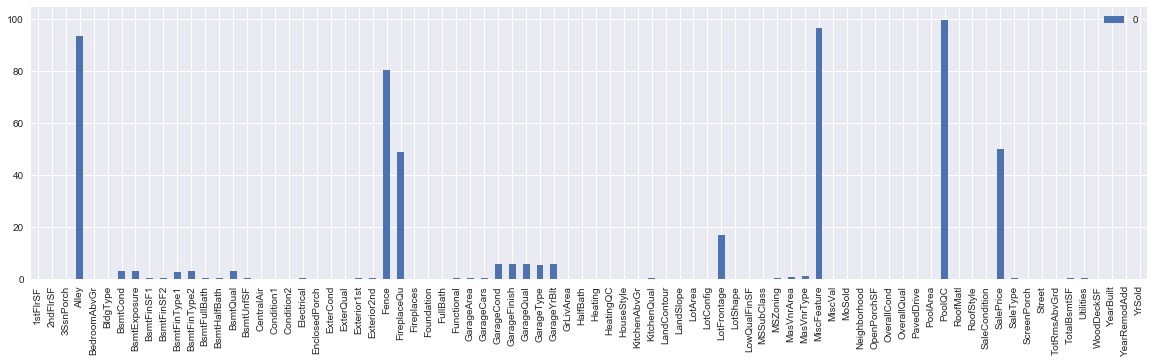

In [6]:
pd.DataFrame(full.isna().sum()*100/full.shape[0]).plot.bar(figsize=(20,5))

* The above plot gives us a summary as percent values for all the variables in the training dataset.
* For the variables with huge proportion of missing value: Alley, PoolQC, Fence and MiscFeature, it's proper to replace NA value with None. Since None is also a type
* Replaced null values with None in the FireplaceQu column both in test and training set.

In [7]:
#NA already existing category
full.update(full[['BsmtCond','BsmtFinType2','BsmtFinType1','BsmtExposure','BsmtQual','GarageType','GarageQual','GarageFinish','GarageCond','FireplaceQu','MiscFeature','Fence','PoolQC','Alley']].fillna('None'))

#none a new category generated
full.update(full[['Electrical','MasVnrType']].fillna('None'))

#nan with zero as constant
full.update(full[['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','BsmtHalfBath','BsmtFullBath','GarageArea','GarageCars','MasVnrArea','TotalBsmtSF']].fillna(0)) #no basement so areas are zero


# Replacing the missing values with mode for the list of variables ['Exterior1st','Exterior2nd','Functional','KitchenQual','MSZoning','SaleType','Utilities']
full['Exterior1st']=full['Exterior1st'].fillna(full.Exterior1st.value_counts().index[0])
full['Exterior2nd']=full['Exterior2nd'].fillna(full.Exterior2nd.value_counts().index[0])
full['Functional']=full['Functional'].fillna(full.Functional.value_counts().index[0])
full['KitchenQual']=full['KitchenQual'].fillna(full.KitchenQual.value_counts().index[0])
full['MSZoning']=full['MSZoning'].fillna(full.MSZoning.value_counts().index[0])
full['SaleType']=full['SaleType'].fillna(full.SaleType.value_counts().index[0])
full['Utilities']=full['Utilities'].fillna(full.Utilities.value_counts().index[0])

#Dropping irrelavent columns from the whole dataset based on the EDA on the training dataset
full= full.drop(['MoSold','GarageQual','PoolArea','MSSubClass'],axis=1)

#GarageQual is repetitive
#PoolQC is mostly NA
#Pool Area is mostly 0
#MSSubClass is a combination of dweiing and year



#filled missing garage years
full['GarageYrBlt'] = full['GarageYrBlt'].fillna(full['YearBuilt'])



#converting years into age 
currentYear = datetime.now().year

full['Age_House']=currentYear-full['YearBuilt']
full['Age_Renovation']=currentYear-full['YearRemodAdd']
full['Garage_age']=currentYear-full['GarageYrBlt']
full = full.drop(['YearBuilt','YearRemodAdd','GarageYrBlt'],axis=1)



# Changing OverallCond into a categorical variable
full['OverallCond'] = full['OverallCond'].astype(str)

# Year and month sold are transformed into categorical features.
full['YrSold'] = full['YrSold'].astype(str)

In [8]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageCond', 'ExterQual', 
        'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'OverallCond', 
        'YrSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lb = LabelEncoder() 
    lb.fit(list(full[c].values)) 
    full[c] = lb.transform(list(full[c].values))
    
    
    
# Adding total sqfootage feature 
full['TotalSF'] = full['TotalBsmtSF'] + full['1stFlrSF'] + full['2ndFlrSF']

In [9]:
#spillitng the data again

train = full[full['SalePrice'].notnull()]
test = full[full['SalePrice'].isnull()]

In [10]:
train_y = train['SalePrice']
train_x = train.drop(['SalePrice'],axis=1)

test_x = test.drop(['SalePrice'],axis=1)

In [11]:
# Get train LotFrontage dummy variables
LotFrontage_Dummies_df = pd.get_dummies(train_x[['LotFrontage', 'MSZoning', 'LotArea', 'LotConfig', 'Neighborhood']])

# Get full dummy variables
# Split the data into LotFrontage known and LotFrontage unknown
LotFrontageKnown = LotFrontage_Dummies_df[LotFrontage_Dummies_df["LotFrontage"].notnull()]
LotFrontageUnknown = LotFrontage_Dummies_df[LotFrontage_Dummies_df["LotFrontage"].isnull()]

# Training data knowing LotFrontage
LotFrontage_Known_X = LotFrontageKnown.drop(["LotFrontage"], axis = 1)
LotFrontage_Known_y = LotFrontageKnown["LotFrontage"]
# Training data unknown LotFrontage
LotFrontage_Unknown_X = LotFrontageUnknown.drop(["LotFrontage"], axis = 1)
# Build model using random forest
from sklearn.ensemble import RandomForestRegressor
rfr=RandomForestRegressor(random_state=1,n_estimators=500,n_jobs=-1)
rfr.fit(LotFrontage_Known_X, LotFrontage_Known_y)
rfr.score(LotFrontage_Known_X, LotFrontage_Known_y)

/Users/vibhz/GWU_rml/env_rml/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


0.9305840449585167

In [12]:
# Predict training data unknown LotFrontage
LotFrontage_Unknown_y = rfr.predict(LotFrontage_Unknown_X)
train_x.loc[train_x["LotFrontage"].isnull(), "LotFrontage"] = LotFrontage_Unknown_y

In [13]:
# Repeat same process for test data
# Get train LotFrontage dummy variables
LotFrontage_Dummies_df = pd.get_dummies(test_x[['LotFrontage', 'MSZoning', 'LotArea', 'LotConfig', 'Neighborhood']])

# Get full dummy variables
# Split the data into LotFrontage known and LotFrontage unknown
LotFrontageKnown = LotFrontage_Dummies_df[LotFrontage_Dummies_df["LotFrontage"].notnull()]
LotFrontageUnknown = LotFrontage_Dummies_df[LotFrontage_Dummies_df["LotFrontage"].isnull()]

# Testing data knowing LotFrontage
LotFrontage_Known_X = LotFrontageKnown.drop(["LotFrontage"], axis = 1)
LotFrontage_Known_y = LotFrontageKnown["LotFrontage"]
# Testing data unknown LotFrontage
LotFrontage_Unknown_X = LotFrontageUnknown.drop(["LotFrontage"], axis = 1)
# Build model using random forest
from sklearn.ensemble import RandomForestRegressor
rfr=RandomForestRegressor(random_state=1,n_estimators=500,n_jobs=-1)
rfr.fit(LotFrontage_Known_X, LotFrontage_Known_y)
rfr.score(LotFrontage_Known_X, LotFrontage_Known_y)

0.9456107979297688

In [14]:
# Predict testing data unknown LotFrontage
LotFrontage_Unknown_y = rfr.predict(LotFrontage_Unknown_X)
test_x.loc[test_x["LotFrontage"].isnull(), "LotFrontage"] = LotFrontage_Unknown_y

In [15]:
train['LotFrontage'] = train_x['LotFrontage']
test['LotFrontage'] = test_x['LotFrontage']

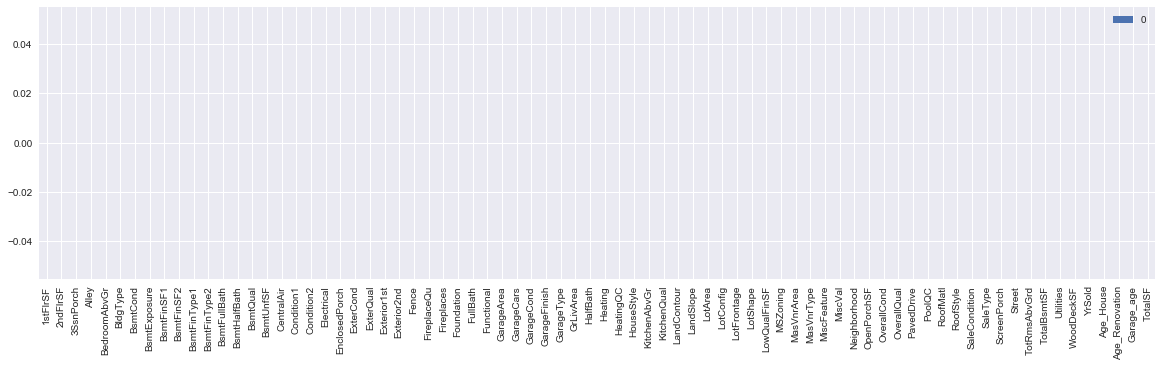

In [16]:
pd.DataFrame(train_x.isna().sum()*100/train_x.shape[0]).plot.bar(figsize=(20,5))

In [17]:
train.to_csv('processed-data/new_train.csv', index=False)
test.to_csv('processed-data/new_test.csv', index=False)

## EDA

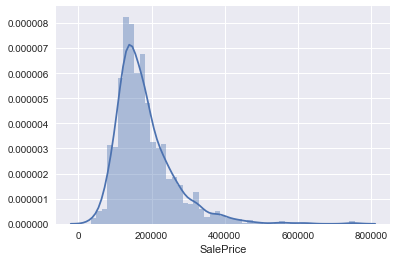

In [18]:
sns.distplot(train_y)

#Deviate from the normal distribution.
#Have appreciable positive skewness.

This gives us the distribution of the target variable taken on a log scale which seems a little skewed.  

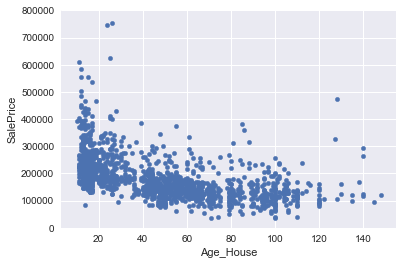

In [19]:
train_data = pd.concat([train_y, train_x], axis=1)

train_data.plot.scatter(x='Age_House', y='SalePrice', ylim=(0,800000))

Creating a new feature as the age of the house tells us that there's definately affect of age on the SalePrice as we can see a decreasing trend in Price as the age increases

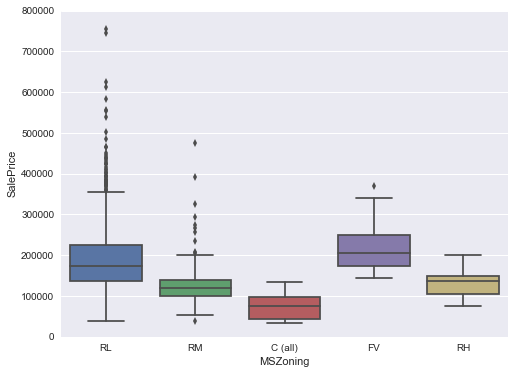

In [20]:
#box plot overallqual/saleprice
var = 'MSZoning'
data = pd.concat([train_data['SalePrice'], train_data[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

This shows us that the mean of different categories of MSZoning, we can see there's a difference in the mean of the categories so keeping this variable in the model seems meaningful. 

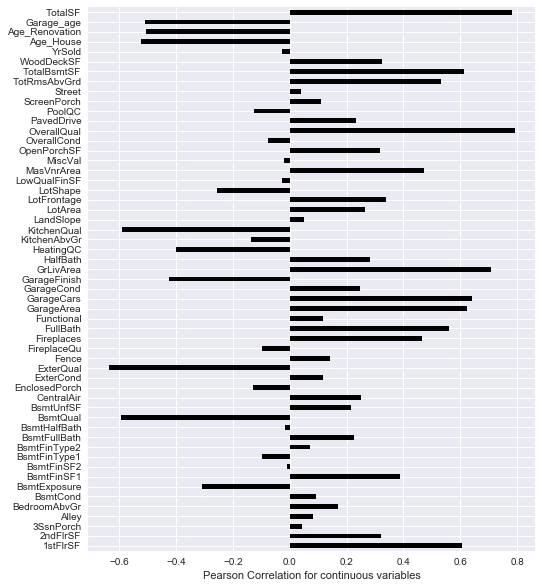

In [21]:
result = pd.concat([train_x, train_y], axis=1)
Corr = result.corr().iloc[:-1,-1]

fig, ax_ = plt.subplots(figsize=(8, 10))
_ =  Corr.plot(kind='barh', ax=ax_, colormap='gnuplot')
_ = ax_.set_xlabel('Pearson Correlation for continuous variables')

The above graph gives us the correlation between the numerical variables in the model:

    Positively Correlated
    - TotalSF
    - OverallQual
    - GrLivArea
    - 1stFlrSF
    
    Negatively Correlated
    - BsmtQual
    - ExterQual
    - Kitchenqual
    - Agehouse

#### MODEL BUILDING

In [23]:
train = pd.read_csv('processed-data/new_train.csv') 
test = pd.read_csv('processed-data/new_test.csv')

In [24]:
train['SalePrice'] = np.log(train['SalePrice'])
test['SalePrice'] = np.log(test['SalePrice'])

train_y = train['SalePrice']
train_x = train.drop(['SalePrice'],axis=1)

test_y = test['SalePrice']
test_x = test.drop(['SalePrice'],axis=1)

### GLM

In [25]:
train_df = pd.get_dummies(train)
test_df = pd.get_dummies(test)

In [26]:
train_y_df = train_df['SalePrice']
train_x_df = train_df.drop('SalePrice', axis = 1)

In [27]:
r = 'SalePrice'
x = list(train_x_df.columns.values)

In [28]:
hf=h2o.H2OFrame(train_df)
gf=h2o.H2OFrame(test_df)

In [30]:
hyper_params = {'alpha': [0, .25, .5, .75, 1]
                ,'lambda':[1, 0.5, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0]
               }

glm = H2OGeneralizedLinearEstimator(family = 'gaussian',standardize = True,lambda_search = True)

# build grid search with previously made GLM and hyperparameters
grid = H2OGridSearch(model = glm, hyper_params = hyper_params,
                     search_criteria = {'strategy': "Cartesian"})


grid.train(x = x, y = r, training_frame = hf,nfolds=5,seed=1)

In [31]:
sorted_grid = grid.get_grid(sort_by='RMSE', decreasing=False)
best_model = sorted_grid.models[0]
best_model.cross_validation_metrics_summary()


Cross-Validation Metrics Summary: 

mean            sd   cv_1_valid  \
0                     mae  0.087561086   0.007938551  0.100381434   
1  mean_residual_deviance  0.019893523   0.007512644  0.024748148   
2                     mse  0.019893523   0.007512644  0.024748148   
3           null_deviance     46.57937      8.305051    57.855732   
4                      r2    0.8746777     0.0461421    0.8728077   
5       residual_deviance    5.8532844      2.366421       7.3502   
6                    rmse   0.13903934    0.02649501   0.15731545   
7                   rmsle   0.01064359  0.0018527234  0.012134987   

     cv_2_valid   cv_3_valid   cv_4_valid   cv_5_valid  
0     0.0823554  0.082669824   0.09026073   0.08213804  
1  0.0117970165  0.030185146  0.018082067  0.014655241  
2  0.0117970165  0.030185146  0.018082067  0.014655241  
3      35.57458    45.474777    43.385708    50.606052  
4    0.90466636    0.7987752    0.8797188    0.9174205  
5     3.3857436     9.146099    5.2076354     4.176744  
6    0.10861407   0.17373873   0.13446958   0.12105884  
7   0.008346687  0.012816845   0.01049446  0.009424972

We can see the best model has a rmsle of 0.01064359 and r2 of 87.5% approx

In [32]:
pred_glm_tr =  best_model.predict(h2o.H2OFrame(train_x_df))
pred_glm_tr = pred_glm_tr.as_data_frame()
co = best_model.coef()

In [33]:
#feature importance for the continuous variables in glm

In [34]:
cc = [key for key in dict(train.dtypes) if dict(train.dtypes)[key] in ['float64', 'int64']]
cc.remove('SalePrice')

In [35]:
cont_coef = pd.DataFrame.from_dict(dict((k, co[k]) for k in cc),orient='index')

In [36]:
cont_coef = cont_coef.rename(columns={ 0: "Beta"})

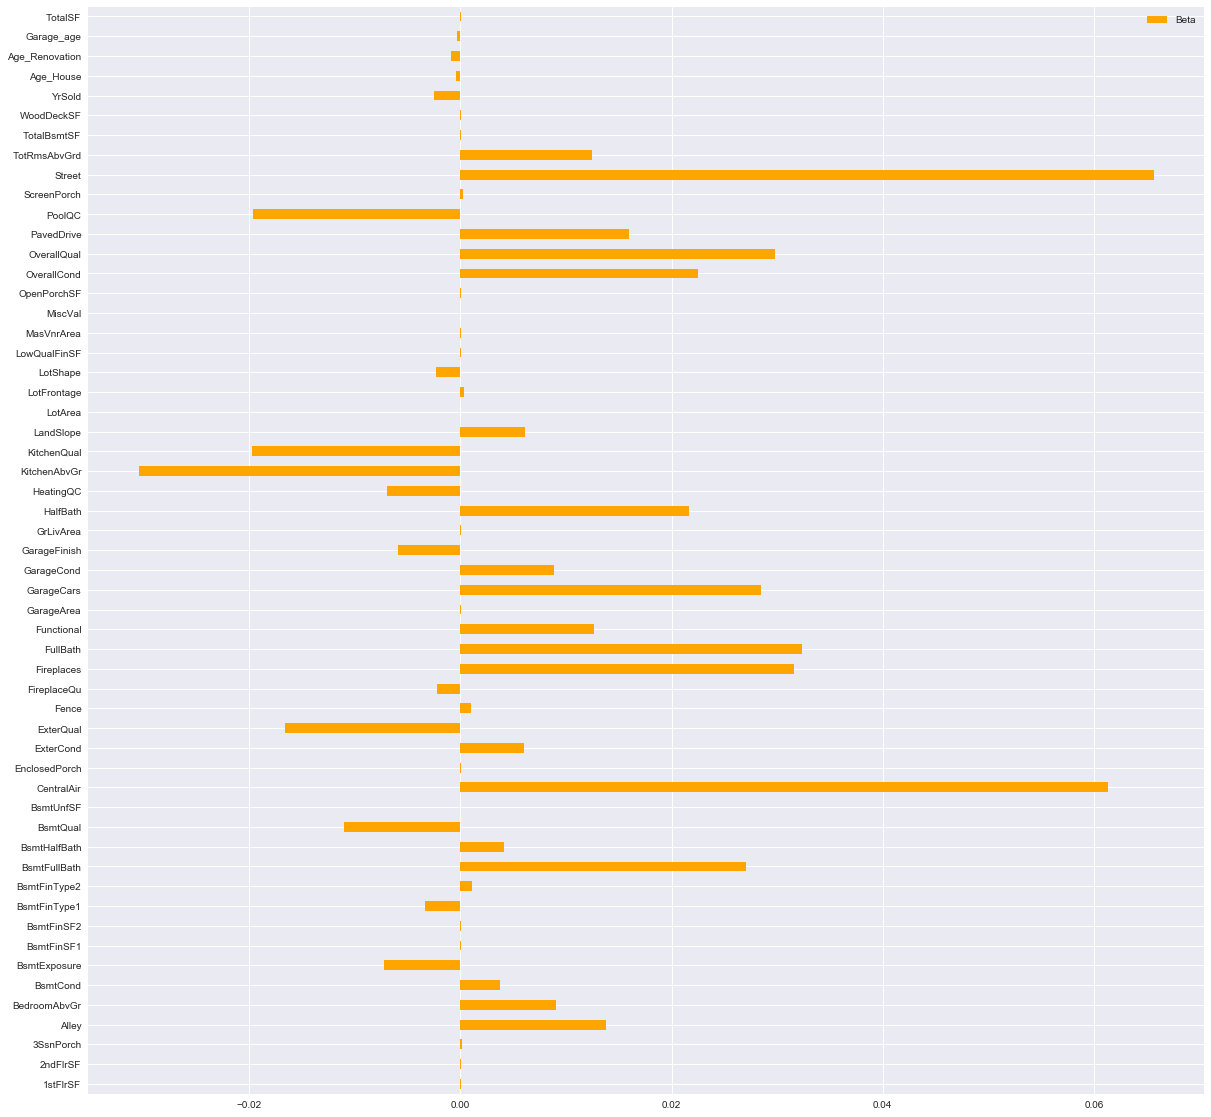

In [37]:
cont_coef.plot.barh(figsize=(20, 20),color='orange')

From the above GLM model we can see that the most important numerical variables for the model:
Street, CentralAir followed by FullBath, Fireplaces and OverallQual - Positive Impact

KitchanAbvGr, PoolQC and ExterQual are the negatively affecting variables in the model. 


* Positive affecting variables mean when we increase the value of that variable we can see an increase in the overall SalePrice and viceversa. 



# GBM

The next step in complexity from the penalized GLM will be a GBM model. The GBM model can fit the data using arbitrarily complex stair-step patterns, as opposed to being locked into the regression function form. 

The goal is to compare the behavior of the monotonic GBM to the penalized GLM and Pearson correlation coefficients to make sure we trust and understand what the monotonic GBM is doing.

In [38]:
X_train, X_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.30, random_state=1111)

In [39]:
X_train = pd.concat([X_train, y_train], axis=1)
X_valid = pd.concat([X_valid, y_valid], axis=1)
X_train_hf = h2o.H2OFrame(X_train)
X_valid_hf = h2o.H2OFrame(X_valid)

SEED  = 1111   # global random seed for better reproducibility


In [40]:
y_name = 'SalePrice'
x_names = list(train.columns.drop('SalePrice'))

predictors = x_names
response = "SalePrice"

In [41]:
params = {'learn_rate': [0.01, 0.05, 0.1], 
          'max_depth': list(range(2,13,2)),
          'ntrees': [20, 50, 80, 110, 140, 170, 200],
          'sample_rate': [0.5,0.6,0.7,0.9,1], 
          'col_sample_rate': [0.2,0.4,0.5,0.6,0.8,1]
          }


# Prepare the grid object
grid = H2OGridSearch(model=H2OGradientBoostingEstimator,   # Model to be trained
                     grid_id='gbm_grid1',
                     hyper_params=params,              # Dictionary of parameters
                     search_criteria={"strategy": "RandomDiscrete"}   # RandomDiscrete
                     )

# Train the Model
grid.train(x=predictors,y=response, 
           training_frame=X_train_hf, 
           validation_frame=X_valid_hf,
           seed = SEED) # Grid Search ID

In [42]:
# Identify the best model generated with least error
sorted_final_grid = grid.get_grid(sort_by='rmsle',decreasing = False)

In [43]:
best_model_id = sorted_final_grid.model_ids[0]
best_gbm_from_grid = h2o.get_model(best_model_id)
best_gbm_from_grid.summary()


Model Summary: 

number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0              170.0                     170.0              18364.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0        2.0        2.0         2.0         3.0         4.0          3.9

- Above is the summary of the best performing model based on the grid search. 

In [44]:
preds_train = best_gbm_from_grid.predict(X_train_hf).exp().as_data_frame()

In [45]:
best_gbm_from_grid.model_performance(X_valid_hf)
#model performance on the test set. 


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.011778798904211008
RMSE: 0.10853017508606078
MAE: 0.07577899196402749
RMSLE: 0.008407261459156386
Mean Residual Deviance: 0.011778798904211008


In [46]:
X_test_hf = h2o.H2OFrame(test_x)
preds = best_gbm_from_grid.predict(X_test_hf)
final_preds = preds.exp()
final_preds = final_preds.as_data_frame()
pred_pandas=final_preds

/Users/vibhz/GWU_rml/env_rml/lib/python3.6/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'Condition2' has levels not trained on: [PosA]
  warnings.warn(w)
/Users/vibhz/GWU_rml/env_rml/lib/python3.6/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'Exterior1st' has levels not trained on: [CBlock]
  warnings.warn(w)
/Users/vibhz/GWU_rml/env_rml/lib/python3.6/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'Exterior2nd' has levels not trained on: [CBlock]
  warnings.warn(w)
/Users/vibhz/GWU_rml/env_rml/lib/python3.6/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'MiscFeature' has levels not trained on: [Gar2]
  warnings.warn(w)
/Users/vibhz/GWU_rml/env_rml/lib/python3.6/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'RoofStyle' has levels not trained on: [Shed]
  warnings.warn(w)


## INTERPRITIBILITY

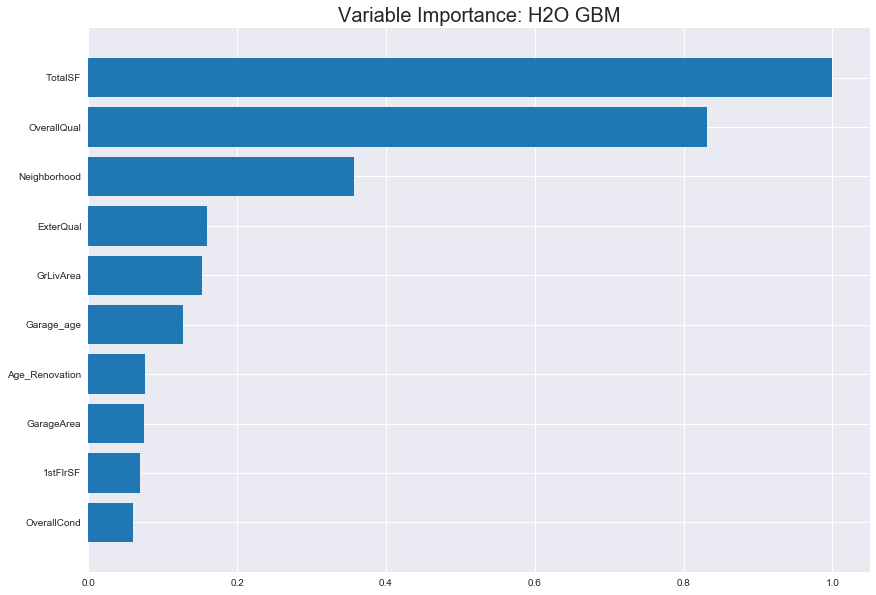

In [47]:
best_gbm_from_grid.varimp_plot()

We can also see from a gradient boosting machine that the most important variable for our model is total square feet followed by overall quality followed by neighborhood excellent quality. 

### SHAPLEY VALUES

In [48]:
contributions = best_gbm_from_grid.predict_contributions(X_test_hf)
#contributions.head(5)

In [49]:
import shap
shap.initjs()
contributions_matrix = contributions.as_data_frame().as_matrix()

X = list(train.columns)
X.remove('SalePrice')
len(X)


/Users/vibhz/GWU_rml/env_rml/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


76

In [50]:
shap_values = contributions_matrix[:,:76]
shap_values.shape



(1459, 76)

In [51]:
expected_value = contributions_matrix[:,:76].min()
expected_value

-0.2488324195146561

In [52]:
shap.force_plot(expected_value, shap_values, X)


The above plot shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red and those pushing the prediction lower are in blue.
Values pushing the model higher than the mean values:

- GarageArea
- GarageArea
- OverallCond

Values pushing the model lower than the mean values:
- OverallQual
- ToalSF
- GrLivArea
- Neighborhood
- MSZoning



The shapley output value is based on the first row (X_test_hf[0,:]) is given below

In [53]:
shap.force_plot(expected_value, shap_values[0,:], X)

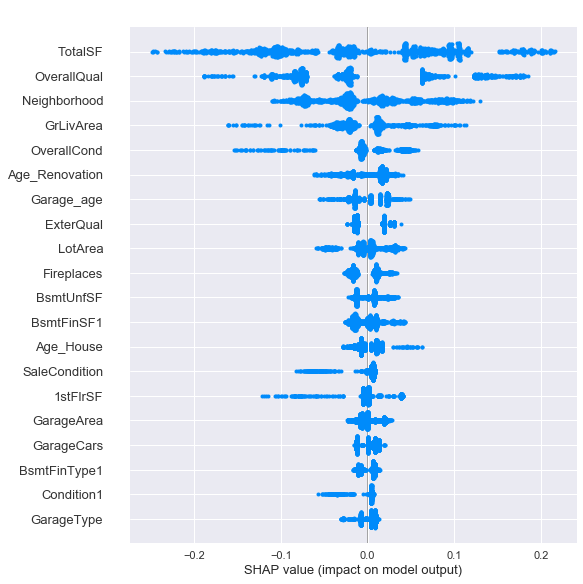

In [54]:
shap.summary_plot(shap_values, X)

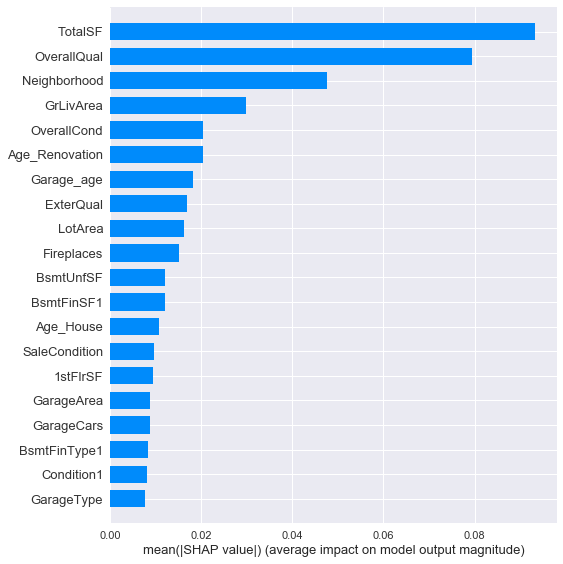

In [55]:
shap.summary_plot(shap_values, X, plot_type="bar")

Global Shapley feature importance is calculated as the average absolute Shapley value for each input feature. The values in the chart below can be interpreted as the mean absolute contribution a feature makes on a model prediction.
Above is the summary plot of the shapley values, this gives us the importance od the features in our model
We can see that the most importnant variables in our model are:
- TotalSF
- OverallQual
- Neighbourhood. 

This shows that our model is not dependent heavily exclusively on just one variable.  

### PARTIAL DEPENDENCE

Partial dependence can be interpreted as the estimated average output of a model across the values of some interesting input feature

We can see the PD for all the miportant variables in the model. 

In [56]:
#Continuous = [key for key in dict(train.dtypes) if dict(train.dtypes)[key] in ['float64', 'int64']]


PartialDependence: Partial Dependence Plot of model gbm_grid1_model_2438 on column 'TotalSF'


totalsf  mean_response  stddev_response  std_error_mean_response
0     334.000000      11.829254         0.315190                 0.009859
1     934.947368      11.829254         0.315190                 0.009859
2    1535.894737      11.863060         0.316107                 0.009888
3    2136.842105      11.954712         0.288459                 0.009023
4    2737.789474      12.082431         0.284277                 0.008892
5    3338.736842      12.119993         0.305744                 0.009564
6    3939.684211      12.191315         0.309323                 0.009676
7    4540.631579      12.212692         0.310356                 0.009708
8    5141.578947      12.212692         0.310356                 0.009708
9    5742.526316      12.212692         0.310356                 0.009708
10   6343.473684      12.212692         0.310356                 0.009708
11   6944.421053      12.212692         0.310356                 0.009708
12   7545.368421      12.212692         0.310356                 0.009708
13   8146.315789      12.212692         0.310356                 0.009708
14   8747.263158      12.212692         0.310356                 0.009708
15   9348.210526      12.212692         0.310356                 0.009708
16   9949.157895      12.212692         0.310356                 0.009708
17  10550.105263      12.212692         0.310356                 0.009708
18  11151.052632      12.212692         0.310356                 0.009708
19  11752.000000      12.212692         0.310356                 0.009708

[]

PartialDependence: Partial Dependence Plot of model gbm_grid1_model_2438 on column 'OverallQual'


overallqual  mean_response  stddev_response  std_error_mean_response
0          1.0      11.879609         0.326483                 0.010213
1          2.0      11.879609         0.326483                 0.010213
2          3.0      11.879609         0.326483                 0.010213
3          4.0      11.933933         0.324944                 0.010164
4          5.0      11.952485         0.315495                 0.009869
5          6.0      12.006055         0.321770                 0.010065
6          7.0      12.097429         0.311476                 0.009743
7          8.0      12.157930         0.312087                 0.009762
8          9.0      12.187988         0.311958                 0.009758
9         10.0      12.187988         0.311958                 0.009758

[]

PartialDependence: Partial Dependence Plot of model gbm_grid1_model_2438 on column '1stFlrSF'


1stflrsf  mean_response  stddev_response  std_error_mean_response
0    334.000000      11.939774         0.391668                 0.012252
1    563.368421      11.950907         0.391443                 0.012245
2    792.736842      12.024157         0.375864                 0.011757
3   1022.105263      12.024157         0.375864                 0.011757
4   1251.473684      12.024157         0.375864                 0.011757
5   1480.842105      12.024157         0.375864                 0.011757
6   1710.210526      12.052084         0.397715                 0.012441
7   1939.578947      12.051841         0.397338                 0.012429
8   2168.947368      12.051841         0.397338                 0.012429
9   2398.315789      12.051841         0.397338                 0.012429
10  2627.684211      12.051841         0.397338                 0.012429
11  2857.052632      12.051841         0.397338                 0.012429
12  3086.421053      12.051841         0.397338                 0.012429
13  3315.789474      12.051841         0.397338                 0.012429
14  3545.157895      12.051841         0.397338                 0.012429
15  3774.526316      12.051841         0.397338                 0.012429
16  4003.894737      12.051841         0.397338                 0.012429
17  4233.263158      12.051841         0.397338                 0.012429
18  4462.631579      12.051841         0.397338                 0.012429
19  4692.000000      12.051841         0.397338                 0.012429

[]


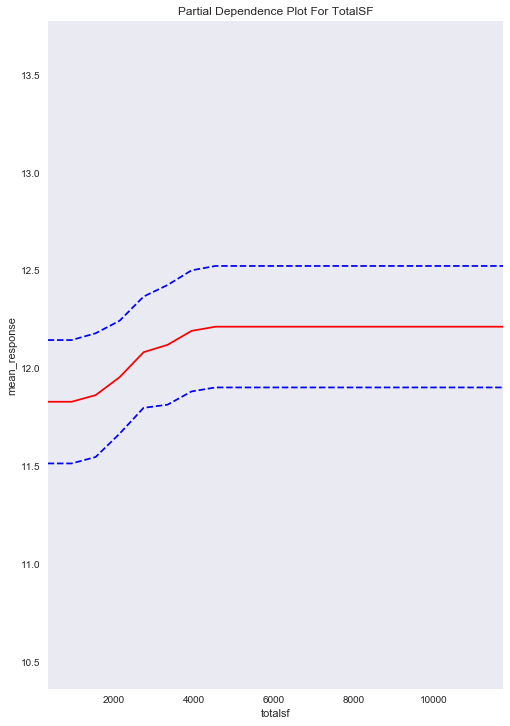

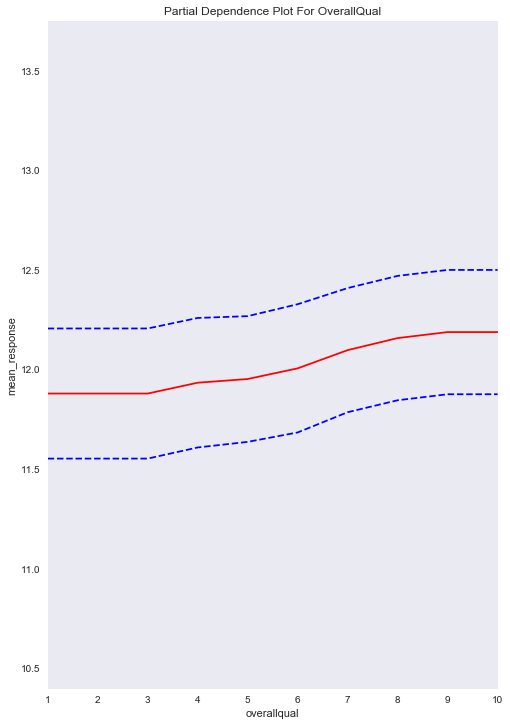

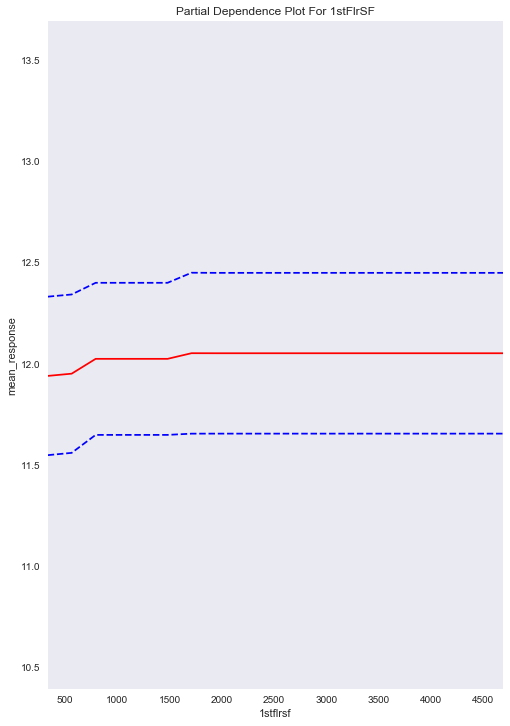

In [57]:
dd = ['TotalSF','OverallQual','1stFlrSF']

for i in dd:
    print(best_gbm_from_grid.partial_plot(data = X_train_hf, cols = [i], server=True, plot = True))


The partial dependence for the GBM show that it picks up on the values as the total square feet of the house increases more than 2000 and becomes constant after the daughter in square feet of the house is 4000 , we can also see a similar trend with the overall quality will we can see a steep jump in the main response of the sales price install quality of the house is greater than 5 and this trend continues until the quality of the house is equal to 8 and becomes constant after that. 
We can see that if the 1stFloorarea is greater than 500 there is a slight increase in the mean value for nothing in space and after becomes constant.  


In [58]:
#print(best_model.partial_plot(data = X_train_hf, cols = ["MSZoning"], server=True, plot = True))

In [59]:
from sklearn.tree import DecisionTreeRegressor,tree
dt = DecisionTreeRegressor(max_depth=10, min_samples_leaf=0.04,
random_state=SEED)
pred_pandas = h2o.as_list(preds)
test_x_dummies = pd.get_dummies(test_x)

In [60]:
dt = dt.fit(test_x_dummies,np.exp(pred_pandas))

In [61]:
dt.score(test_x_dummies,np.exp(pred_pandas))

0.9012228157679073

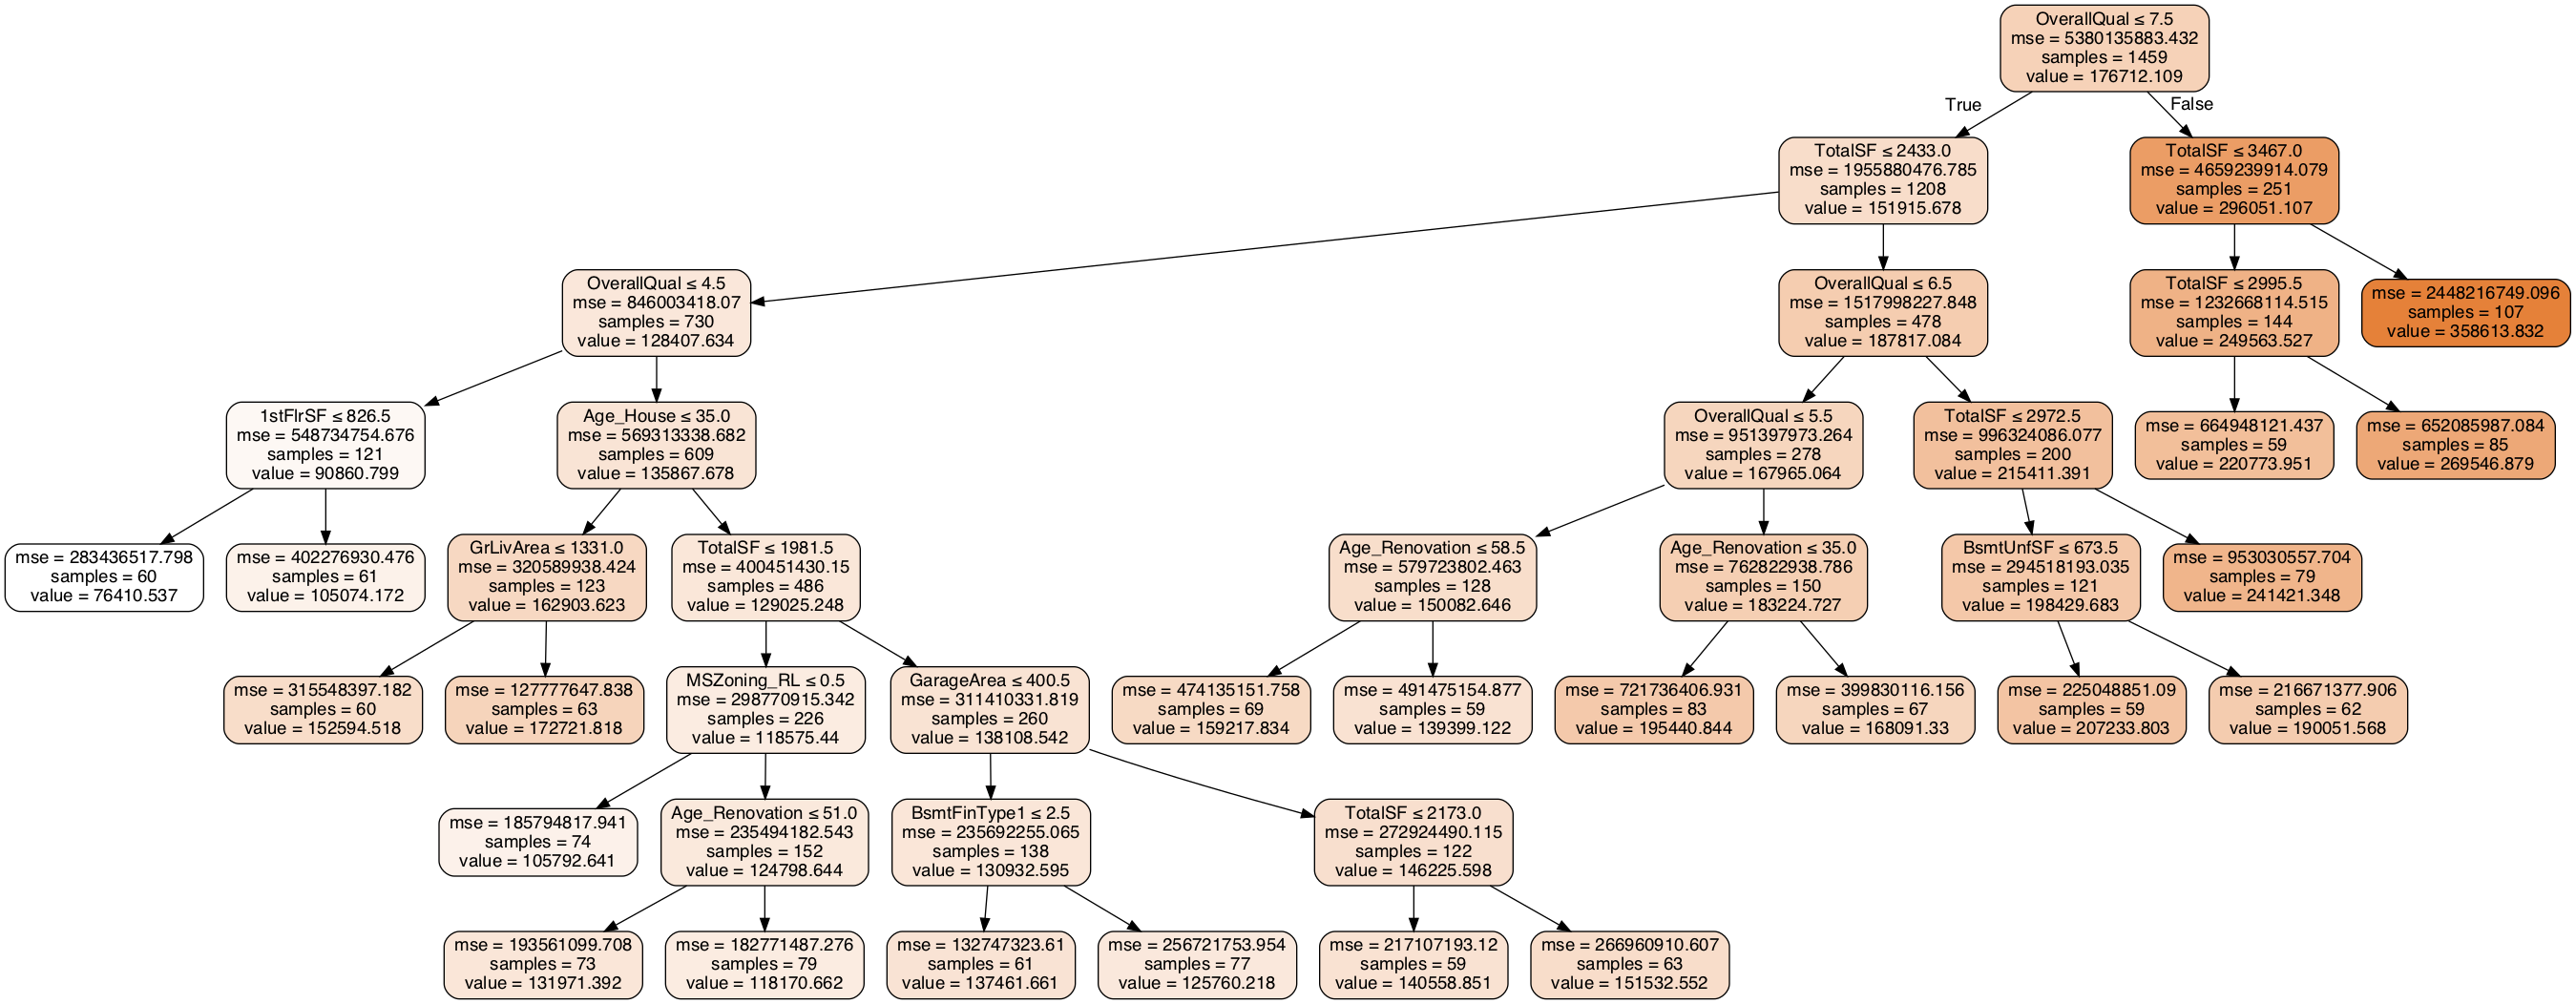

In [62]:

feature_cols = list(test_x_dummies.columns.values)

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

The displayed tree serves as a flowchart summary for the best_gbm model. The square nodes represent decision cut points and the circular terminal nodes are estimated predicted probabilities.

We can see the dominatring effect of the totalsf and the overallqual of the house in the tree. 
The surroagte decision tree explains our model to 90% accuracy and helps us build trust on our model as the consistency of the surrogate model and the gbm tell us the same story regarding the most important variables. 

Surrogate moedel using CARTs arew very easy to explain to any client if asked why does any house corresponds to a higher price. 

### SAVING THE MODEL

### RESIDUAL ANALYSIS

In [63]:
residual = np.exp(train['SalePrice']).sub(preds_train['exp(predict)'], axis = 0).abs()

In [64]:
residual = pd.DataFrame(residual,columns=['Residual'])

In [65]:
residual['SalePrice']= np.exp(train['SalePrice'])

In [66]:
residual = residual.fillna(0)

In [67]:
df = pd.concat([residual,train_x],axis=1)

In [68]:
residual.mean()

Residual      55385.327277
SalePrice    180921.195890
dtype: float64

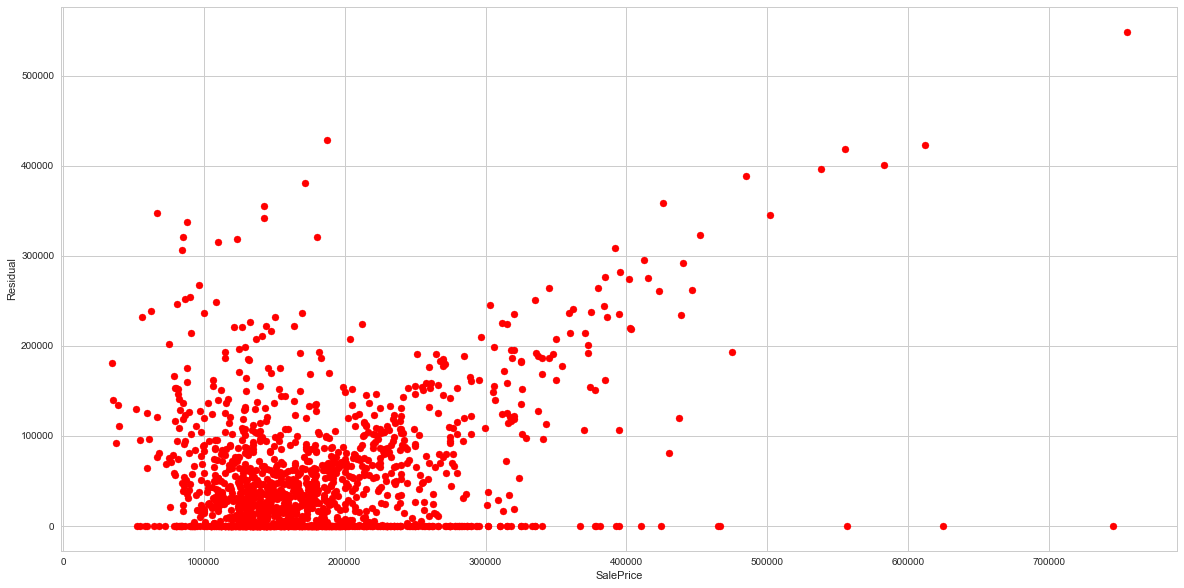

In [69]:
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(residual['SalePrice'],residual['Residual'],color='r')
plt.xlabel('SalePrice')
plt.ylabel('Residual')
plt.show()

We see that our model doesn't show any general trend for residuals for sales prices lesser then 300,000 and we can see that the residence tend to increase as the sales prices go up this shows that our model get strained on the majority cluster which is between $100,000 and $300,000 this shows that our model is sensitive to the residuals.

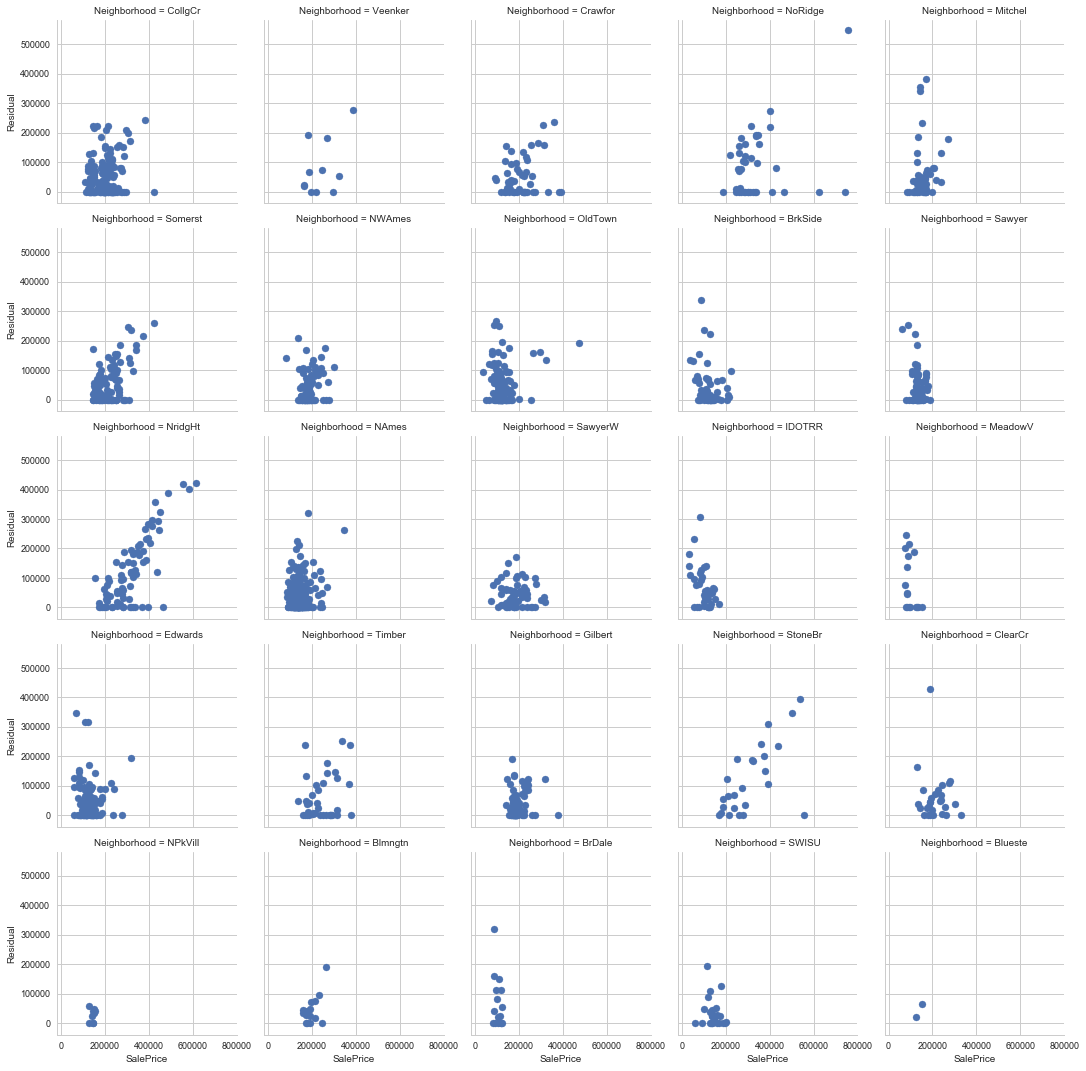

In [70]:
import seaborn as sns
sns.set(font_scale=0.9)                                         
sns.set_style('whitegrid') 

groups = df.groupby(x_names)

sorted_ = df.sort_values(by='Neighborhood') 

g=sns.FacetGrid(df, col="Neighborhood",col_wrap=5)
g= (g.map(plt.scatter, "SalePrice", "Residual").add_legend())

Splitting up to see if there is a trend unless you do this for a specific neighborhood or in general there is a trend of residuals with respect to the neighborhood.

We can see for the neighborhood Edwards we have higher value of residuals as the sale price increases and same is followed for SWISU , other neighborhoods don't show a generic trend in The residuals with respect to the sales price. 

These are one of the few neighborhoods where the GBM model is struggling to predict the sales price accurately 


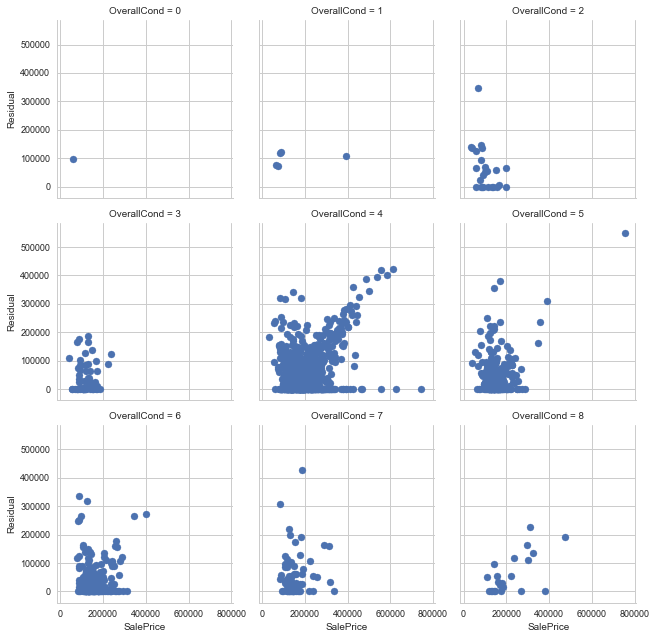

In [71]:
sns.set(font_scale=0.9)                                         
sns.set_style('whitegrid') 

groups = df.groupby(x_names)

sorted_ = df.sort_values(by='OverallCond') 

g=sns.FacetGrid(df, col="OverallCond",col_wrap=3)
g= (g.map(plt.scatter, "SalePrice", "Residual").add_legend())

But if you do this can also be plotted for another important input variable that is overall quality when plotted we can see when overall quality is equal to 7 dirty GBM is struggling to accurately predict the sales price. 

## COMPARISON OF THE PERFORMANCE OF THE MODEL

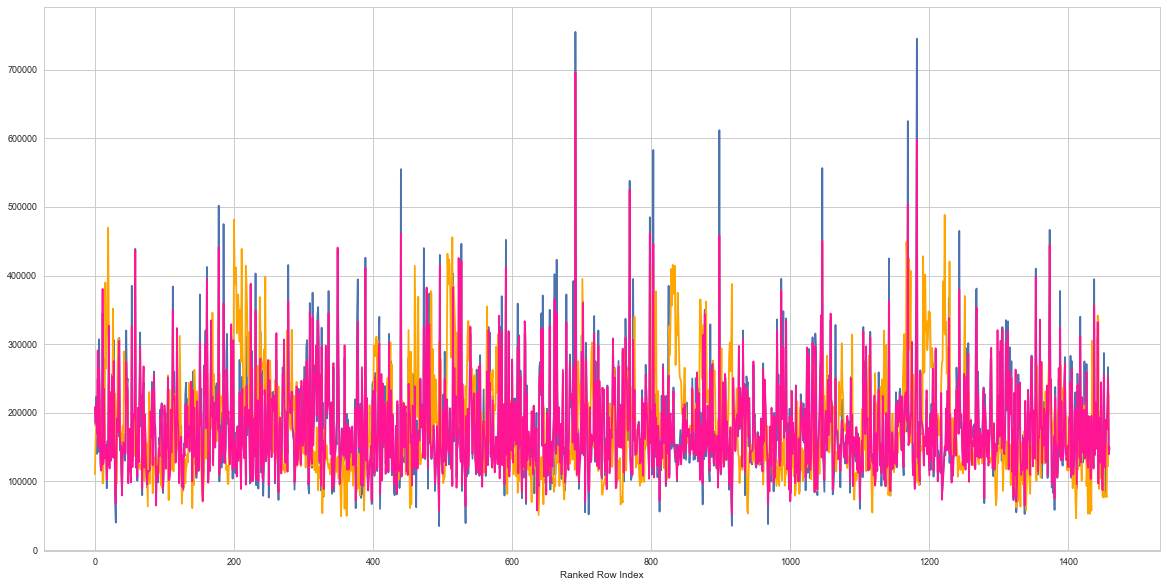

In [72]:
fig, ax = plt.subplots(figsize=(20, 10)) 
plt.plot(df['SalePrice'])
plt.plot(np.exp(pred_pandas['predict']),color='orange')
plt.plot(np.exp(pred_glm_tr['predict']),color='deeppink')
_ = ax.set_xlabel('Ranked Row Index')

[<matplotlib.lines.Line2D at 0x7fd637428320>]

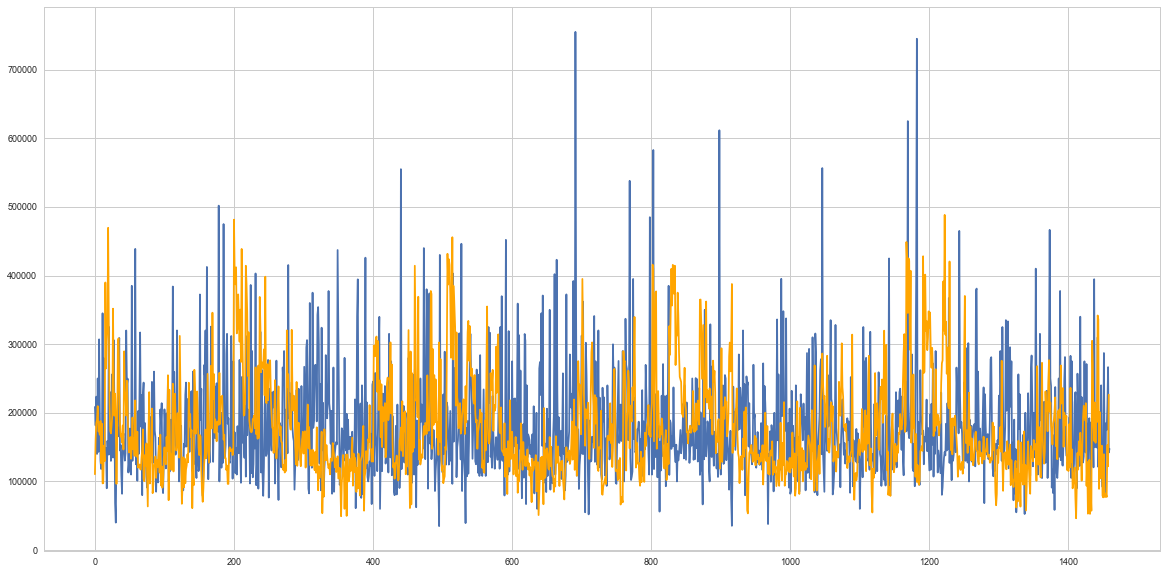

In [73]:
fig, ax = plt.subplots(figsize=(20, 10)) 
plt.plot(df['SalePrice'])
plt.plot(np.exp(pred_pandas['predict']),color='orange')

[<matplotlib.lines.Line2D at 0x7fd637414278>]

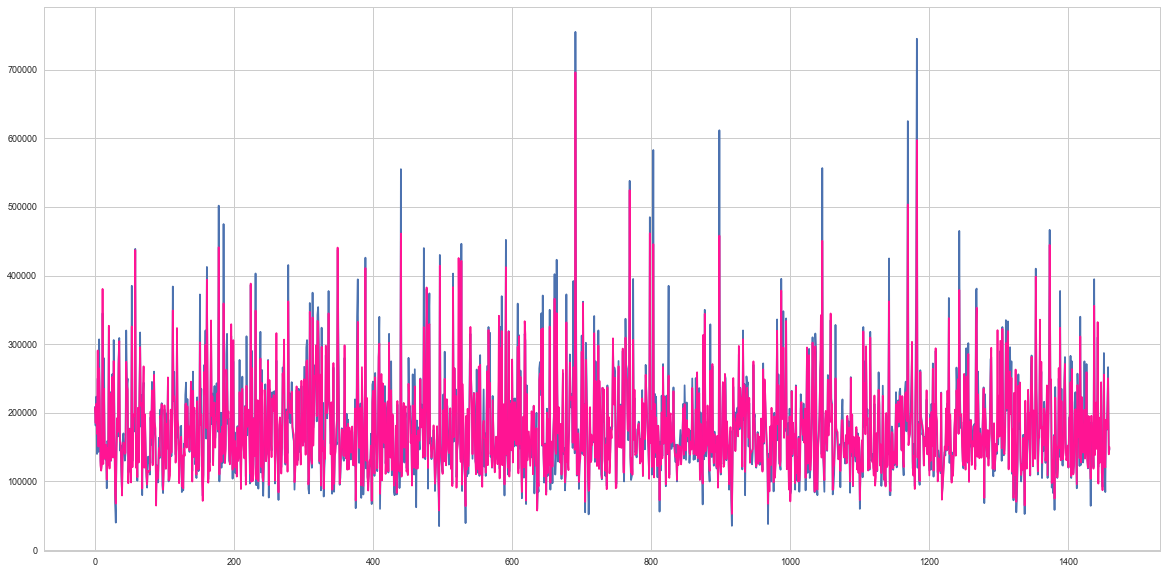

In [74]:
fig, ax = plt.subplots(figsize=(20, 10)) 
plt.plot(df['SalePrice'])
plt.plot(np.exp(pred_glm_tr['predict']),color='deeppink')

We can also compare the performance of our best elastic net model and GBM model, the first glove overlaps the actual sales price and the predictions by both of our models. 

The second graph shows us a comparison between the actual sales price and the predictions normal gradient boosting machine we can see that the gradient boosting machine strongly trains around the majority values and is able to capture the effect of outliers in contrast with the elastic net model where we are not able to capture many outliers.

Overall our gradient boosting machine seems to perform better and looks more reliable compared to the elastic net model.   

